# CLASIFICAR ggF y VBF CON MACHINE LEARNING

## PAQUETES

In [2]:
# dataframes 
import numpy as np
# import pandas as pd
import polars as pd

# cargar archivos
import uproot
from tqdm import tqdm # sirve para ver la linea de carga al cargar los archivos
import sys
import yaml

# gráficos
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

# funcion de xgboost que clasifica
from xgboost import XGBClassifier
import xgboost as xgb

# graficar el arbol de desiciones del modelo, rcparams es para que se vea HD
from xgboost import plot_tree
from matplotlib.pylab import rcParams

# medir que tan bueno es el modelo
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# encontrar mejor modelo (validacion)
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score

# ver la prueba de ks
from scipy.stats import kstest

# funciones creadas
from lectura import *
from formulas import *
from cortes import *
from graficar import *
from machine_learning import *
from metricas import *

# para recargar los modulos mientras los voy debugeando
%load_ext autoreload
%autoreload 2

# LECTURA DE DATOS

In [3]:
########################################################
########### LECTURA DATOS PREVIOS YAML #################
########################################################

# cargar archivo yaml
path = "/home/tomilee/Desktop/Universidad/dark_photons/proyecto_investigacion/codigo/"
data_yaml = read_data_yaml('parametros_ml_after_cut.yaml')      #Parámetros del calo

# de data_yaml obtenemos los nombres de los datasets
vbf_data = data_yaml['VBF'].values() #esto devuelve solo los valores de cada variable.
ggf_data = data_yaml['ggF'].values() #esto devuelve solo los valores de cada variable.

# de data_yaml obtenemos los nombres de las variables
variables = data_yaml['recover_branches']
# de data_yaml obtenemos las escalas de las variables
scales = data_yaml['scale_variable']

# de data_yaml obtenemos los nombres de los cortes y los valores de los cortes menores y mayores
cuts = data_yaml['cuts']

In [4]:
########################################################
############# LECTURA DATOS ROOT FILES #################
########################################################
df_all = read_datasets(vbf_data, ggf_data, variables, scales, path)
df_all

  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

samples/VBF/frvz_vbf_500757


 25%|██▌       | 2/8 [00:00<00:02,  2.03it/s]

samples/VBF/frvz_vbf_500758


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

samples/VBF/frvz_vbf_500759


 50%|█████     | 4/8 [00:01<00:01,  2.22it/s]

samples/VBF/frvz_vbf_500760


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

samples/VBF/frvz_vbf_500761


 75%|███████▌  | 6/8 [00:02<00:00,  2.10it/s]

samples/VBF/frvz_vbf_500762


 88%|████████▊ | 7/8 [00:03<00:00,  2.19it/s]

samples/VBF/frvz_vbf_500763


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


samples/VBF/frvz_vbf_500764


100%|██████████| 9/9 [00:17<00:00,  1.89s/it]


njet30          mjj      detajj  \
origin df_name                                                        
VBF    samples/VBF/frvz_vbf_500757       2  1316.194214    5.130603   
       samples/VBF/frvz_vbf_500757       7  2287.880371    7.156201   
       samples/VBF/frvz_vbf_500757       2  1568.506470    6.255918   
       samples/VBF/frvz_vbf_500757       4   471.740875    1.960242   
       samples/VBF/frvz_vbf_500757       8  1150.059692    4.557185   
...                                    ...          ...         ...   
ggF    samples/ggF/frvz_ggf_508893       1    -0.999000 -999.000000   
       samples/ggF/frvz_ggf_508893       3   240.689178    1.942230   
       samples/ggF/frvz_ggf_508893       2   143.422470    2.548514   
       samples/ggF/frvz_ggf_508893       0    -0.999000 -999.000000   
       samples/ggF/frvz_ggf_508893       0    -0.999000 -999.000000   

                                        dphijj         MET  scale1fb  \
origin df_name                                                         
VBF    samples/VBF/frvz_vbf_500757    1.032967  177.043106  0.000486   
       samples/VBF/frvz_vbf_500757   -2.580441  101.195091  0.000502   
       samples/VBF/frvz_vbf_500757   -1.375577  130.909744  0.000429   
       samples/VBF/frvz_vbf_500757    2.980181  491.291687  0.000531   
       samples/VBF/frvz_vbf_500757    2.197970  115.439743  0.000014   
...                                        ...         ...       ...   
ggF    samples/ggF/frvz_ggf_508893 -999.000000   40.554482  0.028479   
       samples/ggF/frvz_ggf_508893    0.768057   76.802452  0.029882   
       samples/ggF/frvz_ggf_508893    2.000947   26.644657  0.029517   
       samples/ggF/frvz_ggf_508893 -999.000000   10.709071  0.029929   
       samples/ggF/frvz_ggf_508893 -999.000000   10.808948  0.030318   

                                      intLumi        jet1_pt    jet1_eta  \
origin df_name                                                             
VBF    samples/VBF/frvz_vbf_500757  44.299999  104969.406250   -3.187121   
       samples/VBF/frvz_vbf_500757  44.299999   72039.820312    3.637084   
       samples/VBF/frvz_vbf_500757  44.299999  120273.304688   -2.382490   
       samples/VBF/frvz_vbf_500757  44.299999  178915.984375    1.259632   
       samples/VBF/frvz_vbf_500757  44.299999  189834.156250   -2.913896   
...                                       ...            ...         ...   
ggF    samples/ggF/frvz_ggf_508893  58.450001   33552.746094    0.995871   
       samples/ggF/frvz_ggf_508893  58.450001  125251.289062   -2.288580   
       samples/ggF/frvz_ggf_508893  58.450001   40318.128906   -3.305732   
       samples/ggF/frvz_ggf_508893  58.450001    -999.000000 -999.000000   
       samples/ggF/frvz_ggf_508893  58.450001    -999.000000 -999.000000   

                                      jet1_phi        jet1_e        jet2_pt  \
origin df_name                                                                
VBF    samples/VBF/frvz_vbf_500757   -0.087903  1.273288e+06   98169.875000   
       samples/VBF/frvz_vbf_500757    0.712928  1.369027e+06   56599.265625   
       samples/VBF/frvz_vbf_500757   -2.404870  6.569827e+05   39280.699219   
       samples/VBF/frvz_vbf_500757   -2.167910  3.411552e+05  133583.312500   
       samples/VBF/frvz_vbf_500757   -1.059290  1.754382e+06   72083.078125   
...                                        ...           ...            ...   
ggF    samples/ggF/frvz_ggf_508893   -2.499207  5.242589e+04    -999.000000   
       samples/ggF/frvz_ggf_508893    1.335905  6.239932e+05   79405.820312   
       samples/ggF/frvz_ggf_508893    0.382778  5.504859e+05   36411.175781   
       samples/ggF/frvz_ggf_508893 -999.000000 -9.990000e+02    -999.000000   
       samples/ggF/frvz_ggf_508893 -999.000000 -9.990000e+02    -999.000000   

                                      jet2_eta    jet2_phi        jet2_e  
origin df_name                                                            
VBF    s

array([[<Axes: title={'center': 'njet30'}>,
        <Axes: title={'center': 'mjj'}>,
        <Axes: title={'center': 'detajj'}>,
        <Axes: title={'center': 'dphijj'}>],
       [<Axes: title={'center': 'MET'}>,
        <Axes: title={'center': 'scale1fb'}>,
        <Axes: title={'center': 'intLumi'}>,
        <Axes: title={'center': 'jet1_pt'}>],
       [<Axes: title={'center': 'jet1_eta'}>,
        <Axes: title={'center': 'jet1_phi'}>,
        <Axes: title={'center': 'jet1_e'}>,
        <Axes: title={'center': 'jet2_pt'}>],
       [<Axes: title={'center': 'jet2_eta'}>,
        <Axes: title={'center': 'jet2_phi'}>,
        <Axes: title={'center': 'jet2_e'}>, <Axes: >]], dtype=object)

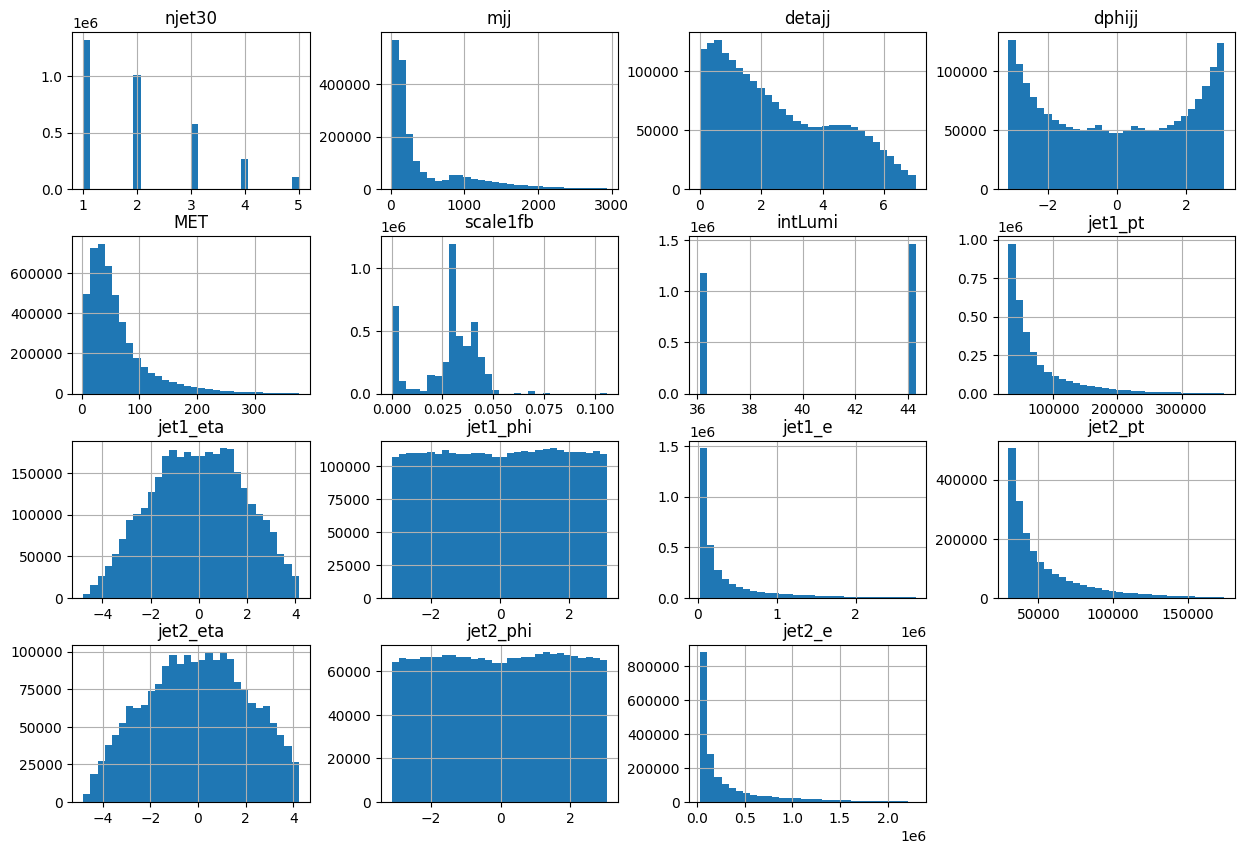

In [5]:
df_plot = df_all[(df_all > df_all.quantile(0.005)) & (df_all < df_all.quantile(0.995))]

df_plot.hist(bins=30, figsize=(15, 10))

# CORTES Y PREPROCESADO

### Para VBF hay un corte mínimo en los dos jets que salen de esta producción (mjj > 900 GeV). En principio ggF no debería tener dos jets que vayan en dirección forward/backward como VBF, por lo que este corte estaría de mas. Para mantener una sincronía en el análisis se tomaron ortogonales, entonces para VBF ocupar mjj > 900 GeV y para ggF mjj < 900 GeV. Entiendo que habría un problema en el entrenamiento, asi que te recomiendo que dejes libre la masa pero que luego hagas un corte de mjj > 900 GeV

In [6]:
#################################################################
#################### PROCESAMIENTO DE DATOS #####################
#################################################################

# hago los cortes definitivos
df_all_cut = do_cuts(df_all, cuts, scales)

# modifico df_all para aplicar ml
df_ml = df_all_cut
df_ml = df_ml.droplevel('df_name')
df_ml = df_ml.drop(['njet30', 'scale1fb', 'intLumi'], axis=1) # omito njet30, intlumi y scale1f
df_ml = df_ml.reset_index(level='origin')
df_ml = pd.get_dummies(df_ml, columns=['origin'], dtype=int)

# HAGO LOS CORTES QUE ENTENDI AL PROFE}
df_ml_vbf = df_ml[(df_ml["origin_VBF"]==1) & (df_ml["mjj"] > 900)]
df_ml_ggf = df_ml[(df_ml["origin_VBF"]==0) & (df_ml["mjj"] < 900)]
df_ml = pd.concat([df_ml_vbf, df_ml_ggf])

# separo entre datos de entrenamiento y datos de validacion
df_X = df_ml.drop(['origin_VBF', 'origin_ggF'], axis=1) 
df_y = df_ml[["origin_VBF"]]

# separo entre datos de entrenamiento y datos de validacion
X_train, X_metrico, y_train, y_metrico = train_test_split(df_X, df_y, test_size=0.3)#, random_state=123)
X_test, X_val, y_test, y_val = train_test_split(X_metrico, y_metrico, test_size=0.5)

df_ml

Numero eventos antes: 4628576
Corte: njet30 entre [1, inf]
Numero eventos despues: 2013265 



,mjj,detajj,dphijj,MET,jet1_pt,jet1_eta,jet1_phi,jet1_e,jet2_pt,jet2_eta,jet2_phi,jet2_e,origin_VBF,origin_ggF
0,1316.194214,5.130603,1.032967,177.043106,104969.406250,-3.187121,-0.087903,1.273288e+06,98169.875000,1.943482,-1.120870,3.498132e+05,1,0
1,2287.880371,7.156201,-2.580441,101.195091,72039.820312,3.637084,0.712928,1.369027e+06,56599.265625,-3.519117,-2.989815,9.561007e+05,1,0
2,1568.506470,6.255918,-1.375577,130.909744,120273.304688,-2.382490,-2.404870,6.569827e+05,39280.699219,3.873428,-1.029293,9.452691e+05,1,0
4,1150.059692,4.557185,2.197970,115.439743,189834.156250,-2.913896,-1.059290,1.754382e+06,72083.078125,1.643289,3.025926,1.938794e+05,1,0
5,1959.747314,5.296212,-0.007301,173.871338,185329.890625,-1.776462,-0.692636,5.636762e+05,104825.007812,3.519750,-0.685335,1.771840e+06,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012571,86.820213,0.779352,3.074377,36.471001,45681.097656,3.302509,-0.662832,6.216837e+05,35162.062500,2.523157,2.545976,2.206442e+05,0,1
2012572,69.304848,0.293507,-2.302855,5.845552,40501.546875,1.277558,-3.141293,7.845353e+04,33459.644531,0.984051,-0.838438,5.148936e+04,0,1
2012573,506.555878,2.252506,-3.031298,27.214394,152246.031250,1.397108,1.148800,3.269545e+05,144588.734375,-0.855398,-2.103087,2.015532e+05,0,1
2012574,240.689178,1.942230,0.768057,76.802452,125251.289062,-2.288580,1.335905,6.239932e+05,79405.820312,-0.346350,0.567848,8.514269e+04,0,1


array([[<Axes: title={'center': 'njet30'}>,
        <Axes: title={'center': 'mjj'}>,
        <Axes: title={'center': 'detajj'}>,
        <Axes: title={'center': 'dphijj'}>],
       [<Axes: title={'center': 'MET'}>,
        <Axes: title={'center': 'scale1fb'}>,
        <Axes: title={'center': 'intLumi'}>,
        <Axes: title={'center': 'jet1_pt'}>],
       [<Axes: title={'center': 'jet1_eta'}>,
        <Axes: title={'center': 'jet1_phi'}>,
        <Axes: title={'center': 'jet1_e'}>,
        <Axes: title={'center': 'jet2_pt'}>],
       [<Axes: title={'center': 'jet2_eta'}>,
        <Axes: title={'center': 'jet2_phi'}>,
        <Axes: title={'center': 'jet2_e'}>, <Axes: >]], dtype=object)

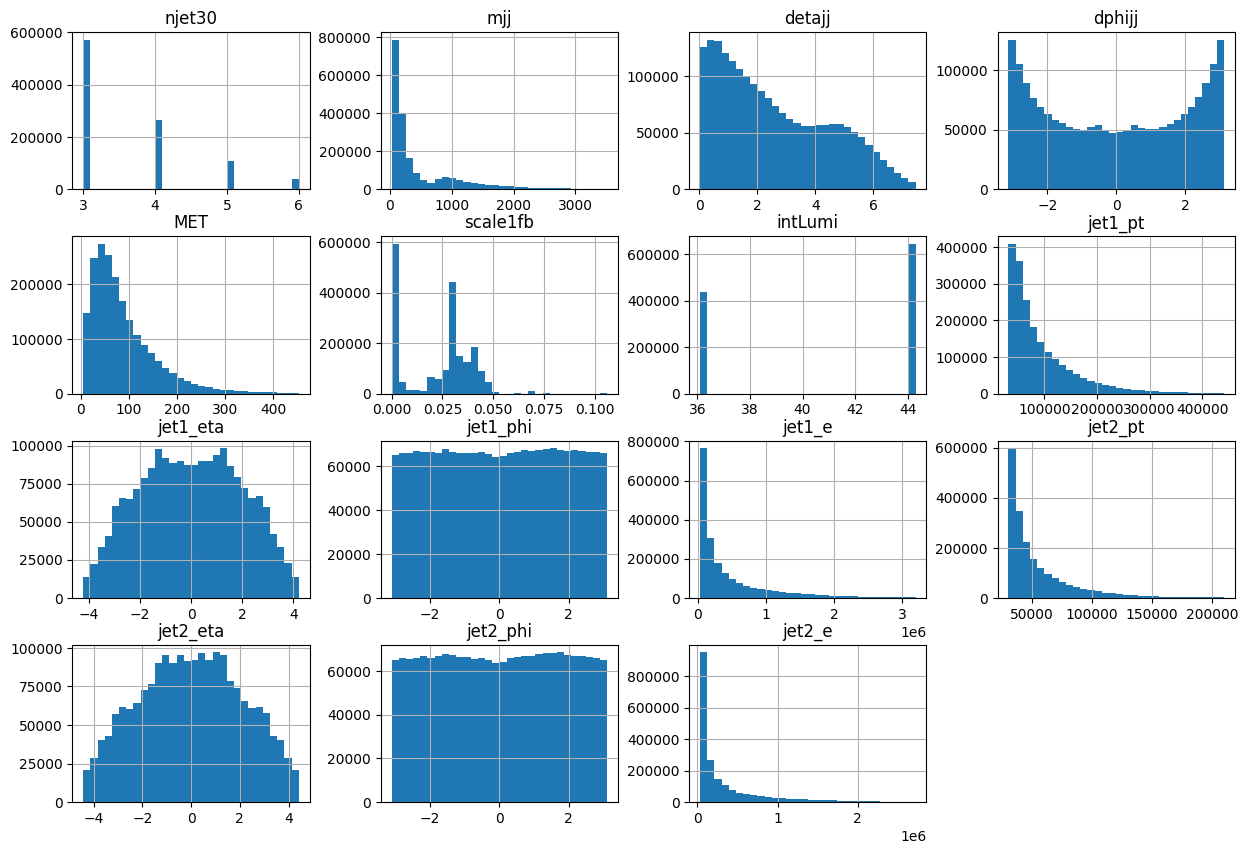

In [7]:
df_plot = df_all_cut[(df_all_cut > df_all_cut.quantile(0.005)) & (df_all_cut < df_all_cut.quantile(0.995))]

df_plot.hist(bins=30, figsize=(15, 10))

# ANALISIS PREVIO

In [8]:
# veamos si hago bien el corte de njet30
# sns.histplot(data = df_all["njet30"], bins=30)
# sí se borraban cosas, habian datos originalmente con njet30 con valores 0 o 1, la cosa que me decía el número de entradas antes y después no estaba actualizado para el código actual

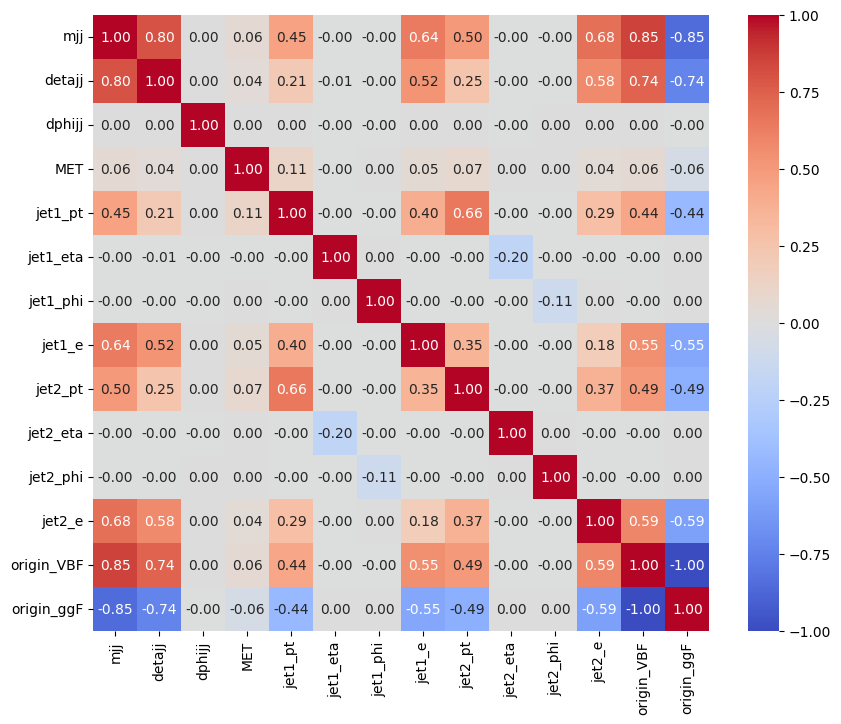

In [9]:
########################################################
##################### CORRELACION ######################
########################################################

plot_correlacion(df_ml)

In [10]:
df_ml

,mjj,detajj,dphijj,MET,jet1_pt,jet1_eta,jet1_phi,jet1_e,jet2_pt,jet2_eta,jet2_phi,jet2_e,origin_VBF,origin_ggF
0,1316.194214,5.130603,1.032967,177.043106,104969.406250,-3.187121,-0.087903,1.273288e+06,98169.875000,1.943482,-1.120870,3.498132e+05,1,0
1,2287.880371,7.156201,-2.580441,101.195091,72039.820312,3.637084,0.712928,1.369027e+06,56599.265625,-3.519117,-2.989815,9.561007e+05,1,0
2,1568.506470,6.255918,-1.375577,130.909744,120273.304688,-2.382490,-2.404870,6.569827e+05,39280.699219,3.873428,-1.029293,9.452691e+05,1,0
4,1150.059692,4.557185,2.197970,115.439743,189834.156250,-2.913896,-1.059290,1.754382e+06,72083.078125,1.643289,3.025926,1.938794e+05,1,0
5,1959.747314,5.296212,-0.007301,173.871338,185329.890625,-1.776462,-0.692636,5.636762e+05,104825.007812,3.519750,-0.685335,1.771840e+06,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012571,86.820213,0.779352,3.074377,36.471001,45681.097656,3.302509,-0.662832,6.216837e+05,35162.062500,2.523157,2.545976,2.206442e+05,0,1
2012572,69.304848,0.293507,-2.302855,5.845552,40501.546875,1.277558,-3.141293,7.845353e+04,33459.644531,0.984051,-0.838438,5.148936e+04,0,1
2012573,506.555878,2.252506,-3.031298,27.214394,152246.031250,1.397108,1.148800,3.269545e+05,144588.734375,-0.855398,-2.103087,2.015532e+05,0,1
2012574,240.689178,1.942230,0.768057,76.802452,125251.289062,-2.288580,1.335905,6.239932e+05,79405.820312,-0.346350,0.567848,8.514269e+04,0,1


In [11]:
# ver las correlaciones en orden de importancia con origin vbf
correlaciones(df_ml, "origin_VBF")

origin_VBF    1.000000
mjj           0.854286
detajj        0.737613
jet2_e        0.592616
jet1_e        0.552975
jet2_pt       0.493619
jet1_pt       0.435107
MET           0.061350
dphijj        0.000477
jet1_phi     -0.000558
jet2_eta     -0.001453
jet1_eta     -0.002244
jet2_phi     -0.002859
origin_ggF   -1.000000
Name: origin_VBF, dtype: float64

borro las de menor relevancia: MET, jet1_phi, jet2_eta, dphijj, jet2_phi, jet1_eta
Ademas borro MET porque no aporta en nada

# PREPROCESADO MEJORADO TRAS ANALISIS

In [12]:
df_ml['origin_ggF']
df_ml2 = df_ml.drop(['jet2_eta', 'jet1_eta', 'jet2_phi', 'MET', 'origin_ggF', 'dphijj', 'jet1_phi'], axis=1)

# separo entre datos de entrenamiento y datos de validacion
df_X = df_ml2.drop(['origin_VBF'], axis=1) 
df_y = df_ml2[["origin_VBF"]]
# df_y = df_ml[["origin_ggF"]]

# separo entre datos de entrenamiento y datos de validacion
X_train, X_metrico, y_train, y_metrico = train_test_split(df_X, df_y, test_size=0.3, random_state=228)
X_test, X_val, y_test, y_val = train_test_split(X_metrico, y_metrico, test_size=0.5, random_state=228)
# X_test, y_test = X_metrico, y_metrico 

df_ml2

,mjj,detajj,jet1_pt,jet1_e,jet2_pt,jet2_e,origin_VBF
0,1316.194214,5.130603,104969.406250,1.273288e+06,98169.875000,3.498132e+05,1
1,2287.880371,7.156201,72039.820312,1.369027e+06,56599.265625,9.561007e+05,1
2,1568.506470,6.255918,120273.304688,6.569827e+05,39280.699219,9.452691e+05,1
4,1150.059692,4.557185,189834.156250,1.754382e+06,72083.078125,1.938794e+05,1
5,1959.747314,5.296212,185329.890625,5.636762e+05,104825.007812,1.771840e+06,1
...,...,...,...,...,...,...,...
2012571,86.820213,0.779352,45681.097656,6.216837e+05,35162.062500,2.206442e+05,0
2012572,69.304848,0.293507,40501.546875,7.845353e+04,33459.644531,5.148936e+04,0
2012573,506.555878,2.252506,152246.031250,3.269545e+05,144588.734375,2.015532e+05,0
2012574,240.689178,1.942230,125251.289062,6.239932e+05,79405.820312,8.514269e+04,0


nota: no cambió en nada el resultado, no afectó las cosas que borré

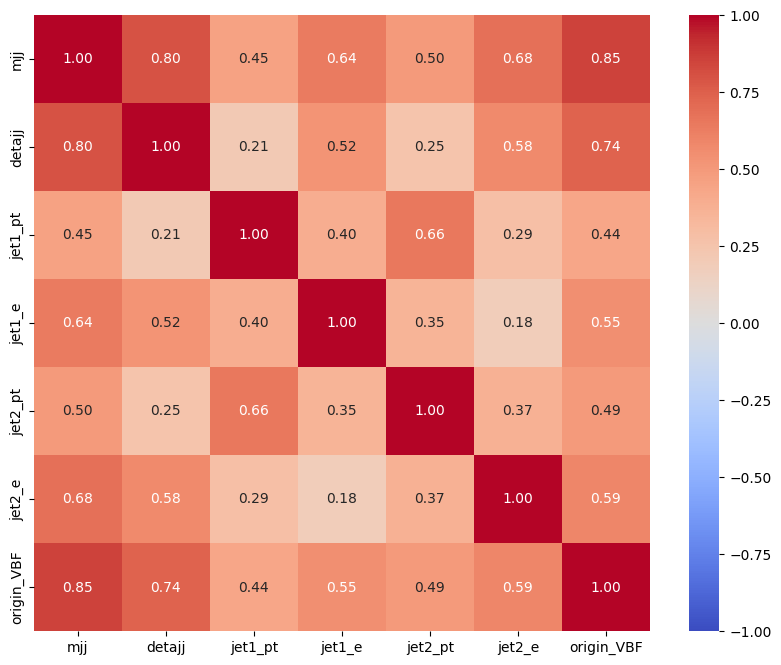

In [13]:
plot_correlacion(df_ml2)

In [14]:
correlaciones(df_ml2, "origin_VBF")

origin_VBF    1.000000
mjj           0.854286
detajj        0.737613
jet2_e        0.592616
jet1_e        0.552975
jet2_pt       0.493619
jet1_pt       0.435107
Name: origin_VBF, dtype: float64

array([[<Axes: title={'center': 'mjj'}>,
        <Axes: title={'center': 'detajj'}>,
        <Axes: title={'center': 'jet1_pt'}>],
       [<Axes: title={'center': 'jet1_e'}>,
        <Axes: title={'center': 'jet2_pt'}>,
        <Axes: title={'center': 'jet2_e'}>],
       [<Axes: title={'center': 'origin_VBF'}>, <Axes: >, <Axes: >]],
      dtype=object)

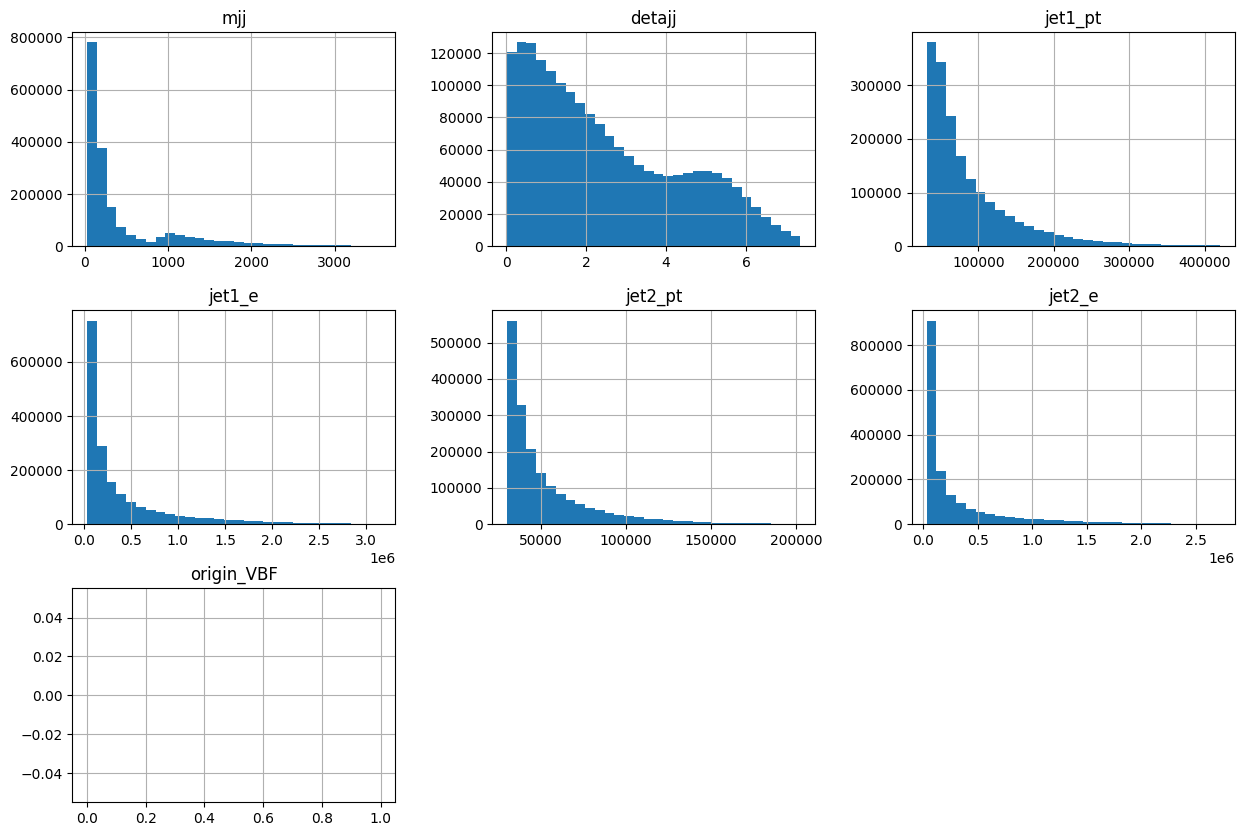

In [15]:
df_plot = df_ml2[(df_ml2 > df_ml2.quantile(0.005)) & (df_ml2 < df_ml2.quantile(0.995))]

df_plot.hist(bins=30, figsize=(15, 10))

# ANALISIS DE DATOS

In [16]:
prueba_ks(df_ml2, "mjj", "norm")

Se rechaza la hipótesis nula, p vale: 0.0. Los datos no siguen una distribución norm.


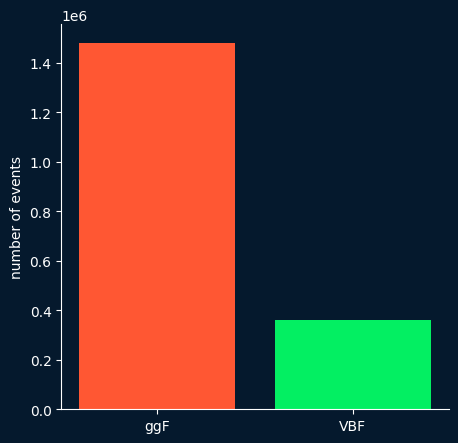

                 mjj    detajj        jet1_pt        jet1_e        jet2_pt  \
0        1316.194214  5.130603  104969.406250  1.273288e+06   98169.875000   
1        2287.880371  7.156201   72039.820312  1.369027e+06   56599.265625   
2        1568.506470  6.255918  120273.304688  6.569827e+05   39280.699219   
4        1150.059692  4.557185  189834.156250  1.754382e+06   72083.078125   
5        1959.747314  5.296212  185329.890625  5.636762e+05  104825.007812   
...              ...       ...            ...           ...            ...   
2012571    86.820213  0.779352   45681.097656  6.216837e+05   35162.062500   
2012572    69.304848  0.293507   40501.546875  7.845353e+04   33459.644531   
2012573   506.555878  2.252506  152246.031250  3.269545e+05  144588.734375   
2012574   240.689178  1.942230  125251.289062  6.239932e+05   79405.820312   
2012575   143.422470  2.548514   40318.128906  5.504859e+05   36411.175781   

               jet2_e  origin_VBF  
0        3.498132e+05      

In [17]:
n_ggF = df_ml2[df_ml2["origin_VBF"] == 0].count()[0]
n_VBF = df_ml2[df_ml2["origin_VBF"] == 1].count()[0]
plot_cantidad_ggf_vbf(n_ggF, n_VBF)
print(df_ml2)

In [18]:
from scipy.stats import ks_2samp

ks_2samp(y_train["origin_VBF"], y_test["origin_VBF"])

KstestResult(statistic=0.0002459938893044633, pvalue=1.0, statistic_location=0, statistic_sign=1)

In [19]:
print(ks_2samp(np.zeros(1000), np.zeros(1000)))
print(ks_2samp(np.ones(1000), np.zeros(1000)))

KstestResult(statistic=0.0, pvalue=1.0, statistic_location=0.0, statistic_sign=1)
KstestResult(statistic=1.0, pvalue=0.0, statistic_location=0.0, statistic_sign=-1)


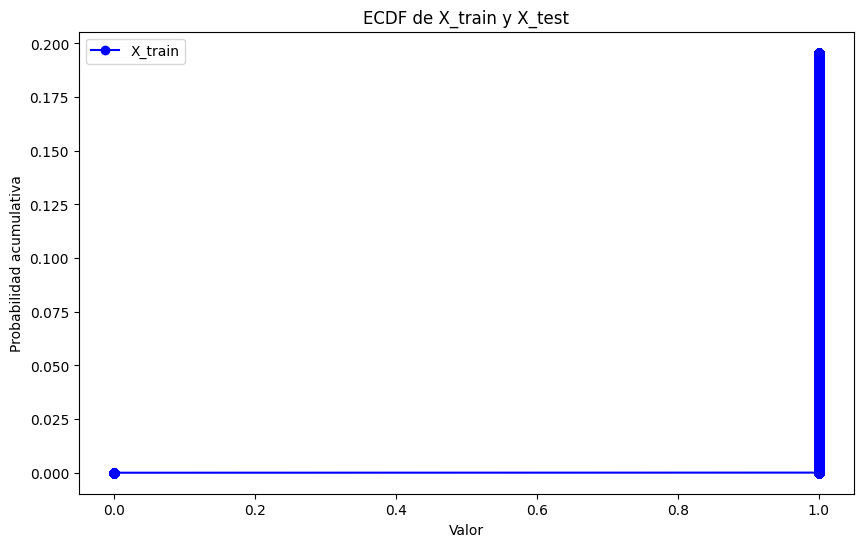

[0.         0.         0.         ... 0.19566583 0.19566661 0.19566738]


In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Supongamos que X_train y X_test son tus dos muestras
ecdf_train = np.cumsum(np.sort(y_train["origin_VBF"])) / len(y_train["origin_VBF"])
ecdf_test = np.cumsum(np.sort(y_test["origin_VBF"])) / len(y_test["origin_VBF"])

plt.figure(figsize=(10, 6))

# Gráfico ECDF para X_train
plt.plot(np.sort(y_train["origin_VBF"]), ecdf_train, label='X_train', marker='o', linestyle='-', color='blue')

# Gráfico ECDF para X_test
# plt.plot(np.sort(y_test["origin_VBF"]), ecdf_test, label='X_test', marker='o', linestyle='-', color='orange')

plt.title('ECDF de X_train y X_test')
plt.xlabel('Valor')
plt.ylabel('Probabilidad acumulativa')
plt.legend()
plt.show()
print(ecdf_train)

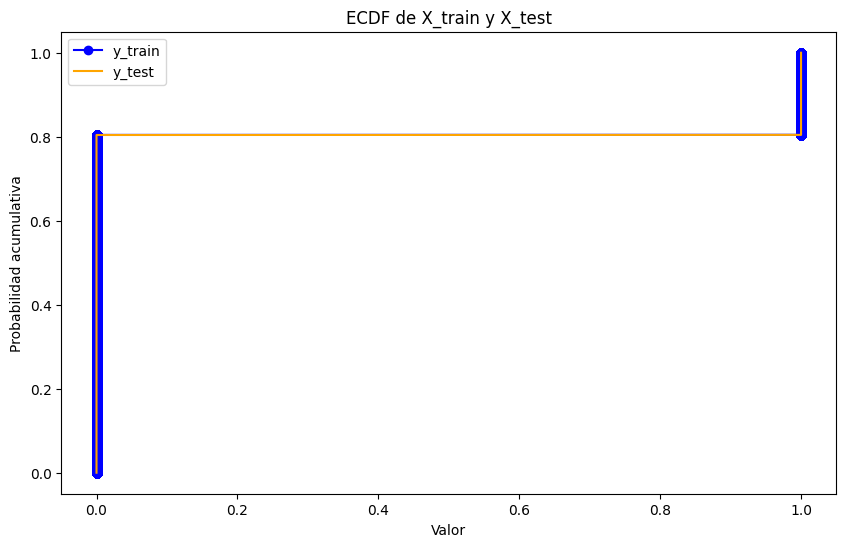

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Supongamos que X_train y X_test son tus dos muestras
y_train_sorted = np.sort(y_train["origin_VBF"])
y_test_sorted = np.sort(y_test["origin_VBF"])

ecdf_train = np.arange(1, len(y_train_sorted) + 1) / len(y_train_sorted)
ecdf_test = np.arange(1, len(y_test_sorted) + 1) / len(y_test_sorted)

plt.figure(figsize=(10, 6))

# Gráfico ECDF para X_train
plt.plot(y_train_sorted, ecdf_train, label='y_train', marker='o', linestyle='-', color='blue')

# Gráfico ECDF para X_test
plt.plot(y_test_sorted, ecdf_test, label='y_test', linestyle='-', color='orange')

plt.title('ECDF de X_train y X_test')
plt.xlabel('Valor')
plt.ylabel('Probabilidad acumulativa')
plt.legend()
plt.show()

# MACHINE LEARNING

In [22]:
########################################################
#################### CLASIFICACION #####################
########################################################
params = {"learning_rate":0.1,
          "max_depth":7, # puse eso porque hay 7 variables
          "n_estimators":500,
          "eval_metric":["logloss", "auc"],
          "verbosity":2,
          "objective":"binary:logistic",
          "gamma":0.1, # esto es para evitar el sobreajuste, limita la creacion de ramas
        #   "device":"cuda"
          }

# params = { "n_estimators": 800,
#             "max_depth": 12,
#             "learning_rate": 0.5,
#             "gamma": 0.6,
#             "min_child_weight": 1,
#             "reg_lambda": 100,
#           #  "scale_pos_weight": scale_pos_weight,
#             "eval_metric": ["logloss", "auc"],
#             # "early_stopping_rounds": 5,
#             "objective":"binary:logistic",
#             "verbosity": 1
#             }

# modelo = XGBClassifier(**params)s
# modelo.fit(X_train, y_train, eval_set=[(X_val, y_val)])


# modelo = do_classification(X_train, y_train, params)
# modelo.fit(X_train, y_train)


# params = { "n_estimators": 10, 
#             "max_depth": 3,
#             "learning_rate": 0.2,
#             "gamma": 0.7, #min loss reduction required to make a further partition on a leaf node of the tree
#             "alpha": 0.05, #L1 regularization, mientras mayor es mas conservador
#             "min_child_weight": 5, #min sum of weights of all observations required in a child
#             "reg_lambda": 50,  # L2 regularization, mientras mayor es mas conservador	

#             "eval_metric": ["logloss", "auc"], #
#             "early_stopping_rounds": 5, # Para evitar overfitting
#             "objective":"binary:logistic",
#             "verbosity": 1
#             }

# model = xgb.XGBClassifier(**params, tree_method='gpu_hist', predictor='gpu_predictor', gpu_id=0)

In [23]:
from bokbokbok.eval_metrics.classification import F1_Score_Binary
from sklearn.metrics import f1_score

params = {'seed': 123,
          "learning_rate":0.1,
          "max_depth":7,
          # "n_estimators":500,
          "eval_metric":["logloss", "auc"],
          "verbosity":2,
          "objective":"binary:logistic",
          "gamma":0.1, # esto es para evitar el sobreajuste, limita la creacion de ramas
          # 'disable_default_eval_metric': 1, # no usa las metricas de evaluacion que puse arribita (eval_metric)
        #   "device":"cuda"
          }

dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_val, y_val)

modelo_boost = xgb.train(params,
          dtrain=dtrain,
          num_boost_round=100,
          early_stopping_rounds=10,
          verbose_eval=10,
          maximize=True,
          custom_metric=F1_Score_Binary(average='binary', XGBoost=True),
          # custom_metric=f1_score(average='micro'),
          evals=[(dtrain, 'dtrain'), (dvalid, 'dvalid')])

modelo = XGBRegressor()
modelo._Booster = modelo_boost

[0]	dtrain-logloss:0.41243	dtrain-auc:1.00000	dtrain-F1:0.00000	dvalid-logloss:0.41254	dvalid-auc:1.00000	dvalid-F1:0.00000
[10]	dtrain-logloss:0.11744	dtrain-auc:1.00000	dtrain-F1:0.99933	dvalid-logloss:0.11746	dvalid-auc:1.00000	dvalid-F1:0.99941
[12]	dtrain-logloss:0.09458	dtrain-auc:1.00000	dtrain-F1:0.99933	dvalid-logloss:0.09460	dvalid-auc:1.00000	dvalid-F1:0.99941


In [24]:
modelo

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [25]:
grafico_decisiones(modelo)

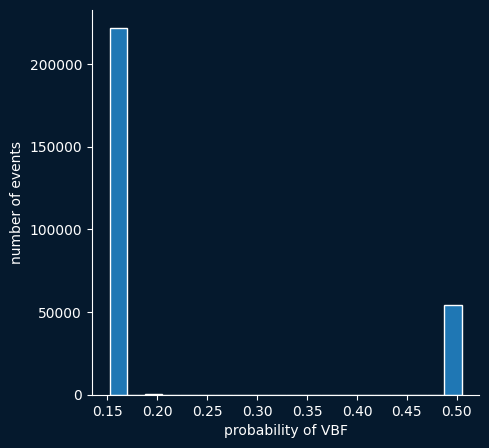

In [26]:
plot_number_events_hist(modelo, X_test)

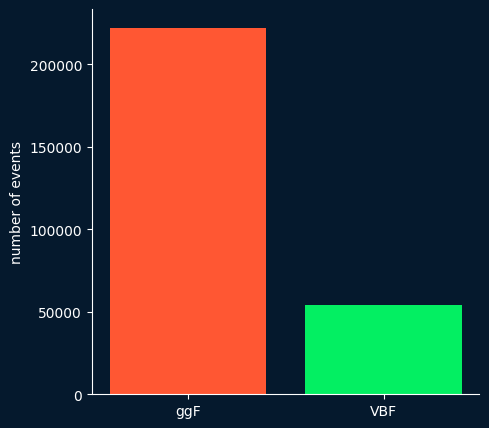

222261
54055
0.8043725300018819
0.1956274699981181


In [27]:
y_pred = modelo.predict(X_test)
n_ggF = y_pred[y_pred<0.5].shape[0]
n_VBF = y_pred[y_pred>0.5].shape[0]

plot_cantidad_ggf_vbf(n_ggF, n_VBF)

ggf_percentage = n_ggF/(n_ggF+n_VBF)
vbf_percentage = n_VBF/(n_ggF+n_VBF)

print(n_ggF)
print(n_VBF)
print(ggf_percentage)
print(vbf_percentage)

In [28]:
from scipy.stats import ks_2samp

ks_2samp(y_test["origin_VBF"], y_pred)

KstestResult(statistic=0.8040866254578092, pvalue=0.0, statistic_location=0.0, statistic_sign=1)

In [29]:
from scipy.stats import ks_2samp

ks_2samp(y_test["origin_VBF"], y_pred>0.5)
# ks_2samp(y_test["origin_VBF"], y_test["origin_VBF"])

KstestResult(statistic=0.0002859045440727348, pvalue=1.0, statistic_location=0, statistic_sign=-1)

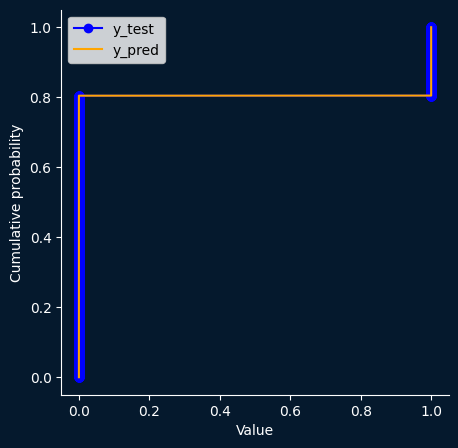

In [30]:
import numpy as np
import matplotlib.pyplot as plt

y_test_sorted = np.sort(y_test["origin_VBF"])
y_pred_sorted = np.sort(y_pred>0.5)
# y_pred_sorted = np.sort(y_pred)

ecdf_test = np.arange(1, len(y_test_sorted) + 1) / len(y_test_sorted)
ecdf_pred = np.arange(1, len(y_pred_sorted) + 1) / len(y_pred_sorted)

fig, ax = plt.subplots(figsize=[5, 5])

# Gráfico ECDF para X_train
plt.plot(y_test_sorted, ecdf_test, label='y_test', marker='o', linestyle='-', color='blue')

# Gráfico ECDF para X_test
plt.plot(y_pred_sorted, ecdf_pred, label='y_pred', linestyle='-', color='orange')

# color del fondo
fondo_color = "#05192d"
colores_hue = {"ggF": "#FF5733", "VBF": "#03ef62"}
blanco = "#ffffff"
fig.set_facecolor(fondo_color)
ax.set_facecolor(fondo_color)

# Eliminar la parte superior y derecha del cuadrado que envuelve el gráfico
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Cambiar el color de los ejes
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

# Cambiar el color de los números en los ejes
ax.tick_params(axis='x', colors='white')  # Eje x
ax.tick_params(axis='y', colors='white')  # Eje y


# plt.title('CDF')
plt.xlabel('Value', color="white")
plt.ylabel('Cumulative probability', color="white")
plt.legend()
plt.show()

KstestResult(statistic=0.00035275534505874173, pvalue=1.0, statistic_location=0.18863498, statistic_sign=1)


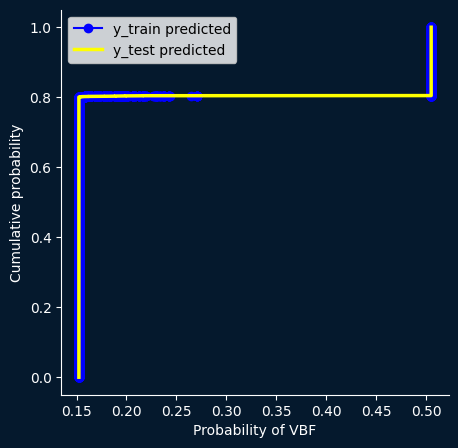

In [31]:
y_pred_test = modelo.predict(X_test)
y_pred_train = modelo.predict(X_train)

print(ks_2samp(y_pred_train, y_pred_test))

y_train_sorted = np.sort(y_pred_train)
y_test_sorted = np.sort(y_pred_test)
# y_pred_sorted = np.sort(y_pred)

cdf_train = np.arange(1, len(y_train_sorted) + 1) / len(y_train_sorted)
cdf_test = np.arange(1, len(y_test_sorted) + 1) / len(y_test_sorted)

fig, ax = plt.subplots(figsize=[5, 5])

# Gráfico ECDF para X_train
plt.plot(y_train_sorted, cdf_train, label='y_train predicted', marker='o', linestyle='-', color='blue')

# Gráfico ECDF para X_test
plt.plot(y_test_sorted, cdf_test, label='y_test predicted', linestyle='-', color='yellow', linewidth=2.5)

# color del fondo
fondo_color = "#05192d"
colores_hue = {"ggF": "#FF5733", "VBF": "#03ef62"}
blanco = "#ffffff"
fig.set_facecolor(fondo_color)
ax.set_facecolor(fondo_color)

# Eliminar la parte superior y derecha del cuadrado que envuelve el gráfico
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Cambiar el color de los ejes
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

# Cambiar el color de los números en los ejes
ax.tick_params(axis='x', colors='white')  # Eje x
ax.tick_params(axis='y', colors='white')  # Eje y


# plt.title('CDF')
plt.xlabel('Probability of VBF', color="white")
plt.ylabel('Cumulative probability', color="white")
plt.legend()
plt.show()

In [32]:
precision(modelo, X_test, y_test)

Precisión del modelo: 99.97%


In [33]:
y_pred = modelo.predict(X_test)
y_pred = y_pred>0.5
matriz = confusion(y_test, y_pred)
pd.DataFrame(matriz)

,0,1
0,54055,79
1,0,222182


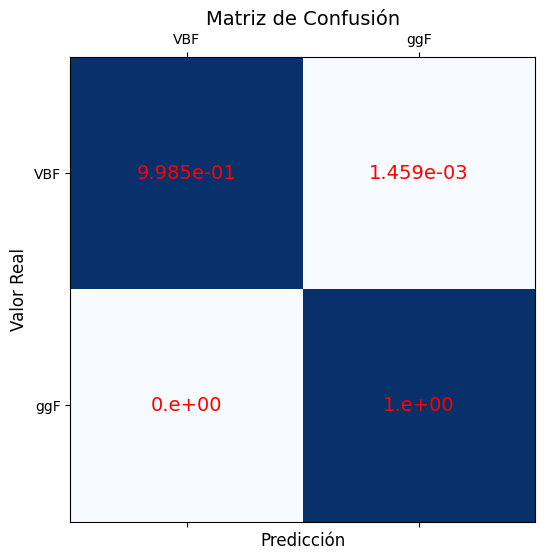

In [34]:
plot_matriz(matriz, porcentaje = False, normalizado=True)

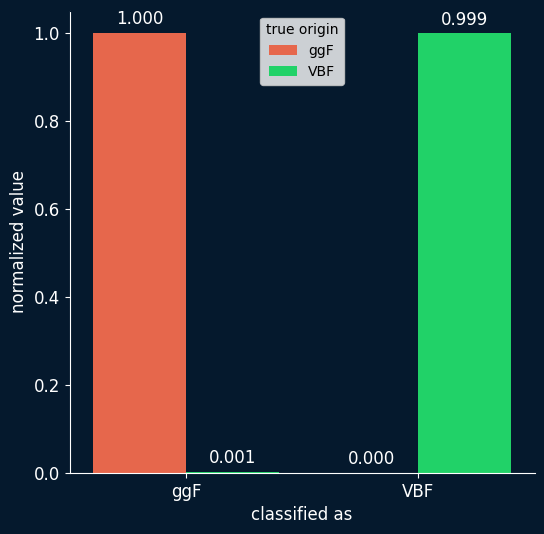

In [35]:
plot_confusion_barras(matriz)

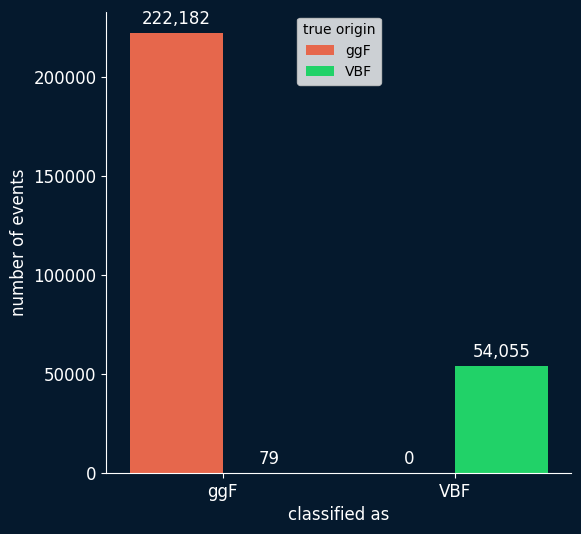

In [36]:
plot_confusion_barras(matriz, normalizado=False)

In [37]:
# Encontrar mejor modelo
# best_model = find_best_model(X_train, y_train, X_test, y_test, X_val, y_val)

In [38]:
from sklearn.metrics import f1_score
y_pred = modelo.predict(X_test)
f1_score(y_test, y_pred>0.5)

0.9992697963748625

In [39]:
modelo

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [40]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# # Supongamos que 'X' es tu conjunto de datos original
# tsne = TSNE(n_components=2, random_state=42)
# X_tsne = tsne.fit_transform(df_X.sample(100, random_state=1))
# # X_tsne = tsne.fit_transform(df_X)

In [41]:
# plt.figure(figsize=[5, 5])
# plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df_y.sample(100, random_state=1).to_numpy(), cmap='viridis', marker='.')
# # plt.plot(X_tsne[:, 0], X_tsne[:, 1])
# plt.show()

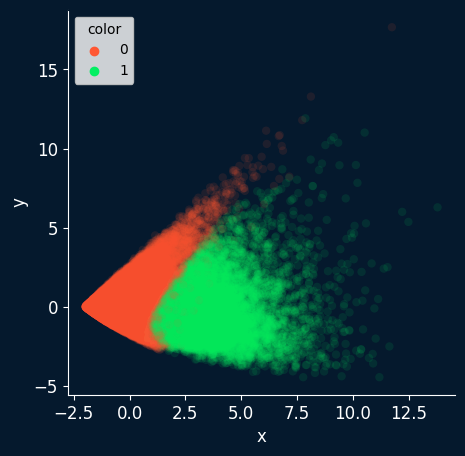

In [42]:
plot_pca_2D(modelo, 
            df_X.sample(100000, random_state=123), 
            df_y.sample(100000, random_state=123))
        #  pd.DataFrame(modelo.predict(df_X)).sample(100000, random_state=123))

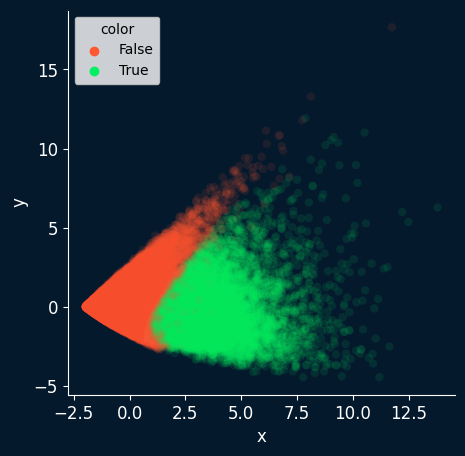

In [43]:
plot_pca_2D(modelo, 
            df_X.sample(100000, random_state=123), 
            # df_y.sample(100000, random_state=123))
            pd.DataFrame(modelo.predict(df_X)>0.5).sample(100000, random_state=123))

In [44]:
importancia = dict(zip(modelo.feature_names_in_, modelo.feature_importances_))
df_importancia = pd.DataFrame(modelo.feature_importances_, index=modelo.feature_names_in_, columns=["importances"])
importancias_ordenadas = df_importancia.sort_values(by=["importances"], ascending=False)
importancias_ordenadas

,importances
mjj,0.999867
jet2_pt,0.000068
detajj,0.000023
jet1_e,0.000015
jet2_e,0.000015
jet1_pt,0.000012


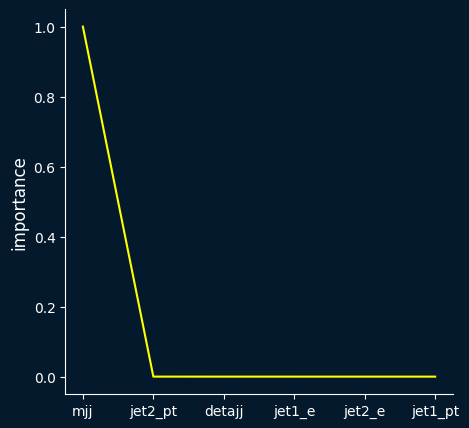

In [45]:
fig, ax = plt.subplots(figsize=[5, 5])
ax.plot(importancias_ordenadas, color='yellow')
ax.set_ylabel("importance", color='white', fontsize=12)

# color del fondo
fondo_color = "#05192d"
colores_hue = {"ggF": "#FF5733", "VBF": "#03ef62"}
blanco = "#ffffff"
fig.set_facecolor(fondo_color)
ax.set_facecolor(fondo_color)

# Eliminar la parte superior y derecha del cuadrado que envuelve el gráfico
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Cambiar el color de los ejes
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

# Cambiar el color de los números en los ejes
ax.tick_params(axis='x', colors='white')  # Eje x
ax.tick_params(axis='y', colors='white')  # Eje y


plt.show()

# OVERTRAINING?

In [46]:
from sklearn.model_selection import learning_curve

# uso el mismo modelo que usé antes, pero sin entrenar, le entrego los mismos parámetros de entrenamiento
modelo_learning_curve = XGBClassifier(**params)

# Genera la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    modelo_learning_curve, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

In [47]:
print(train_sizes)
print(train_scores)
print(test_scores)
print(np.mean(train_scores, axis=1))

[ 103157  206315  309473  412631  515789  618947  722105  825263  928421
 1031579]
[[0.99991275 0.99993214 0.99993214 0.99993214 0.99993214]
 [0.99987883 0.99993699 0.99993699 0.99993699 0.99993699]
 [0.9997415  0.99983844 0.99981582 0.99981582 0.99981582]
 [0.99994668 0.9999588  0.99975765 0.99975765 0.99975765]
 [0.99996316 0.99997286 0.9998449  0.9997848  0.9997848 ]
 [0.9997835  0.99977543 0.99979481 0.99991922 0.99991922]
 [0.99962609 0.99963579 0.99965656 0.99994045 0.99994045]
 [0.9996898  0.99971161 0.99974311 0.99973342 0.99980491]
 [0.99974042 0.99976735 0.9997555  0.99976519 0.99967041]
 [0.9997402  0.99975959 0.99975184 0.99975571 0.99977122]]
[[0.99874755 0.99949204 0.99955408 0.99944551 0.99946877]
 [0.99926714 0.99964327 0.99973633 0.99963163 0.99969755]
 [0.99947653 0.9995502  0.99941061 0.99929429 0.99940286]
 [0.99994959 0.99993408 0.99930204 0.99925939 0.99922449]
 [0.99994571 0.99995347 0.99976347 0.99955796 0.99958898]
 [0.99977122 0.99968204 0.99975959 0.99982939 

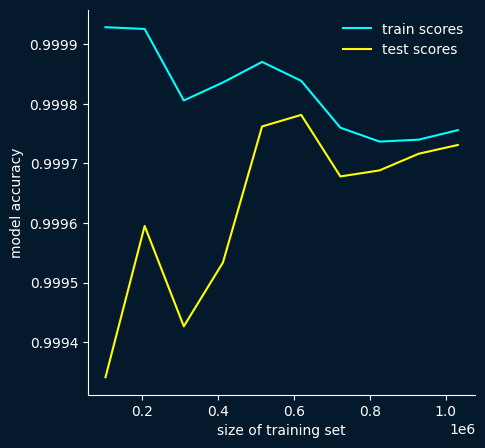

In [48]:
fig, ax = plt.subplots(figsize=[5, 5])
ax.plot(train_sizes, np.mean(train_scores, axis=1), label="train scores", color = "#00FFFF")
ax.plot(train_sizes, np.mean(test_scores, axis=1), label="test scores", color = "yellow")
ax.set_xlabel("size of training set", color="white")
ax.set_ylabel("model accuracy", color="white")
# ax.legend(frameon=False)
# for text in legend.get_texts():
#     text.set_color('white')

legend = ax.legend(["train scores", "test scores"], frameon=False)
for text in legend.get_texts():
    text.set_color('white')


# color del fondo
fondo_color = "#05192d"
colores_hue = {"ggF": "#FF5733", "VBF": "#03ef62"}
blanco = "#ffffff"
fig.set_facecolor(fondo_color)
ax.set_facecolor(fondo_color)

# Eliminar la parte superior y derecha del cuadrado que envuelve el gráfico
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Cambiar el color de los ejes
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

# Cambiar el color de los números en los ejes
ax.tick_params(axis='x', colors='white')  # Eje x
ax.tick_params(axis='y', colors='white')  # Eje y


plt.show()

In [49]:
import sklearn
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [50]:
# uso el mismo modelo que usé antes, pero sin entrenar, le entrego los mismos parámetros de entrenamiento
modelo_validacion_cruzada = XGBClassifier(**params)

# Realiza validación cruzada
cv_scores = cross_val_score(modelo_validacion_cruzada, X_train, y_train, cv=5, scoring='f1')

cv_scores

array([0.99936544, 0.99925633, 0.99941506, 0.99922656, 0.99929601])

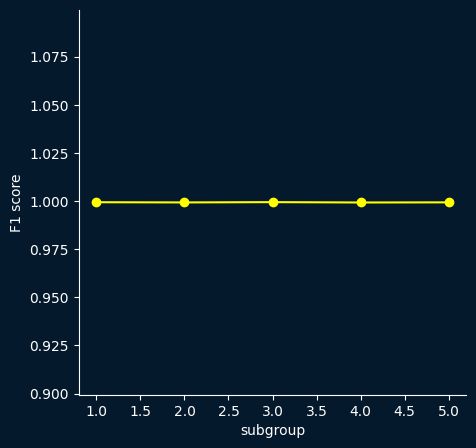

In [51]:
fig, ax = plt.subplots(figsize=[5, 5])
ax.plot(range(1,6),cv_scores, color = "yellow")
ax.scatter(range(1,6),cv_scores, color = "yellow")
ax.set_xlabel("subgroup", color = "white")
ax.set_ylabel("F1 score", color = "white")
ax.set_ylim([cv_scores[0]-0.1, cv_scores[0]+0.1])

# color del fondo
fondo_color = "#05192d"
colores_hue = {"ggF": "#FF5733", "VBF": "#03ef62"}
blanco = "#ffffff"
fig.set_facecolor(fondo_color)
ax.set_facecolor(fondo_color)

# Eliminar la parte superior y derecha del cuadrado que envuelve el gráfico
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Cambiar el color de los ejes
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

# Cambiar el color de los números en los ejes
ax.tick_params(axis='x', colors='white')  # Eje x
ax.tick_params(axis='y', colors='white')  # Eje y


plt.show()

In [52]:
# residuos
# y_test_numpy = y_test.to_numpy().T[0]
# y_pred = modelo.predict(X_test)
# print(y_test_numpy)
# print(y_pred)
# residuos = y_test_numpy - y_pred
# # residuos = residuos.sample(100)
# print(residuos)
# fig, ax = plt.subplots(figsize=[5, 5])
# ax.hist(residuos, bins=100, color="yellow")
# ax.set_xlabel("residual (y_test - y_pred)", color="white")
# ax.set_ylabel("count", color="white")

# # color del fondo
# fondo_color = "#05192d"
# colores_hue = {"ggF": "#FF5733", "VBF": "#03ef62"}
# blanco = "#ffffff"
# fig.set_facecolor(fondo_color)
# ax.set_facecolor(fondo_color)

# # Eliminar la parte superior y derecha del cuadrado que envuelve el gráfico
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# # Cambiar el color de los ejes
# ax.spines['bottom'].set_color('white')
# ax.spines['left'].set_color('white')

# # Cambiar el color de los números en los ejes
# ax.tick_params(axis='x', colors='white')  # Eje x
# ax.tick_params(axis='y', colors='white')  # Eje y


# plt.show()

# HACER EL CORTE FINAL

In [53]:
#################################################################
#################### PROCESAMIENTO DE DATOS #####################
#################################################################

# hago los cortes definitivos
df_all_cut = do_cuts(df_all, cuts, scales)

# modifico df_all para aplicar ml
df_ml_3 = df_all_cut
df_ml_3 = df_ml_3.droplevel('df_name')
df_ml_3 = df_ml_3.drop(['njet30', 'scale1fb', 'intLumi'], axis=1) # omito njet30, intlumi y scale1f
df_ml_3 = df_ml_3.reset_index(level='origin')
df_ml_3= pd.get_dummies(df_ml_3, columns=['origin'], dtype=int)

# hago el corte de despues
df_ml_3 = df_ml_3[df_ml_3["mjj"] > 900]

# HAGO LOS CORTES QUE ENTENDI AL PROFE}
# df_ml_vbf = df_ml[(df_ml["origin_VBF"]==1) & (df_ml["mjj"] > 900)]
# df_ml_ggf = df_ml[(df_ml["origin_VBF"]==0) & (df_ml["mjj"] < 900)]
# df_ml = pd.concat([df_ml_vbf, df_ml_ggf])

# separo entre datos de entrenamiento y datos de validacion
df_X = df_ml_3.drop(['origin_VBF', 'origin_ggF'], axis=1) 
df_y = df_ml_3[["origin_VBF"]]

# separo entre datos de entrenamiento y datos de validacion
X_train, X_metrico, y_train, y_metrico = train_test_split(df_X, df_y, test_size=0.3)#, random_state=123)
X_test, X_val, y_test, y_val = train_test_split(X_metrico, y_metrico, test_size=0.5)

df_ml_3

Numero eventos antes: 4628576
Corte: njet30 entre [1, inf]
Numero eventos despues: 2013265 



,mjj,detajj,dphijj,MET,jet1_pt,jet1_eta,jet1_phi,jet1_e,jet2_pt,jet2_eta,jet2_phi,jet2_e,origin_VBF,origin_ggF
0,1316.194214,5.130603,1.032967,177.043106,104969.406250,-3.187121,-0.087903,1.273288e+06,98169.875000,1.943482,-1.120870,3.498132e+05,1,0
1,2287.880371,7.156201,-2.580441,101.195091,72039.820312,3.637084,0.712928,1.369027e+06,56599.265625,-3.519117,-2.989815,9.561007e+05,1,0
2,1568.506470,6.255918,-1.375577,130.909744,120273.304688,-2.382490,-2.404870,6.569827e+05,39280.699219,3.873428,-1.029293,9.452691e+05,1,0
4,1150.059692,4.557185,2.197970,115.439743,189834.156250,-2.913896,-1.059290,1.754382e+06,72083.078125,1.643289,3.025926,1.938794e+05,1,0
5,1959.747314,5.296212,-0.007301,173.871338,185329.890625,-1.776462,-0.692636,5.636762e+05,104825.007812,3.519750,-0.685335,1.771840e+06,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012398,1375.437012,5.910862,-1.310179,206.011978,153233.453125,-2.751994,-2.272271,1.205820e+06,33497.703125,3.158869,-0.962092,3.950761e+05,0,1
2012424,1298.385620,5.570216,1.490798,204.691193,94238.859375,2.544895,1.564830,6.042351e+05,68172.960938,-3.025321,0.074032,7.038728e+05,0,1
2012431,1024.361084,6.604571,-2.378259,30.073345,43778.152344,3.034697,2.696079,4.563027e+05,32387.500000,-3.569874,-1.208847,5.755651e+05,0,1
2012440,1099.484253,6.322570,-0.535331,151.870178,51457.390625,-3.545921,1.085866,8.928492e+05,42295.820312,2.776649,1.621197,3.411398e+05,0,1


In [54]:
df_ml_4 = df_ml_3.drop(['jet2_eta', 'jet1_eta', 'jet2_phi', 'MET', 'origin_ggF', 'dphijj', 'jet1_phi'], axis=1)

# separo entre datos de entrenamiento y datos de validacion
df_X = df_ml_4.drop(['origin_VBF'], axis=1) 
df_y = df_ml_4[["origin_VBF"]]
# df_y = df_ml[["origin_ggF"]]

# separo entre datos de entrenamiento y datos de validacion
X_train, X_metrico, y_train, y_metrico = train_test_split(df_X, df_y, test_size=0.3, random_state=228)
X_test, X_val, y_test, y_val = train_test_split(X_metrico, y_metrico, test_size=0.5, random_state=228)
# X_test, y_test = X_metrico, y_metrico 

df_ml_4

,mjj,detajj,jet1_pt,jet1_e,jet2_pt,jet2_e,origin_VBF
0,1316.194214,5.130603,104969.406250,1.273288e+06,98169.875000,3.498132e+05,1
1,2287.880371,7.156201,72039.820312,1.369027e+06,56599.265625,9.561007e+05,1
2,1568.506470,6.255918,120273.304688,6.569827e+05,39280.699219,9.452691e+05,1
4,1150.059692,4.557185,189834.156250,1.754382e+06,72083.078125,1.938794e+05,1
5,1959.747314,5.296212,185329.890625,5.636762e+05,104825.007812,1.771840e+06,1
...,...,...,...,...,...,...,...
2012398,1375.437012,5.910862,153233.453125,1.205820e+06,33497.703125,3.950761e+05,0
2012424,1298.385620,5.570216,94238.859375,6.042351e+05,68172.960938,7.038728e+05,0
2012431,1024.361084,6.604571,43778.152344,4.563027e+05,32387.500000,5.755651e+05,0
2012440,1099.484253,6.322570,51457.390625,8.928492e+05,42295.820312,3.411398e+05,0


In [55]:
X_test["mjj"].min()

900.00073

In [56]:
precision(modelo, X_test, y_test)

Precisión del modelo: 89.75%


In [57]:
y_pred = modelo.predict(X_test)
y_pred = y_pred>0.5
matriz = confusion(y_test, y_pred)
pd.DataFrame(matriz)

,0,1
0,53900,82
1,6078,17


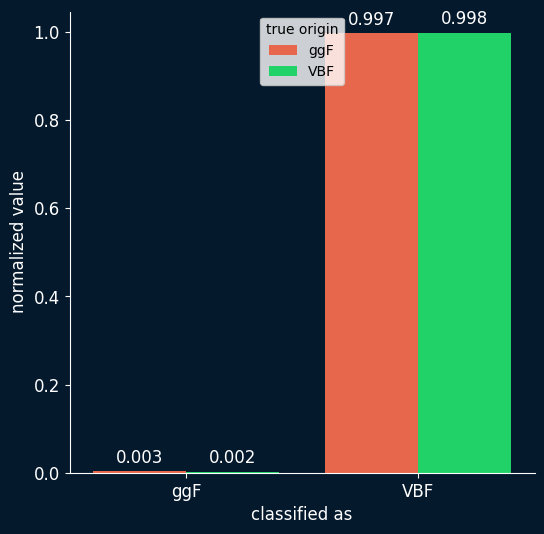

In [58]:
plot_confusion_barras(matriz)

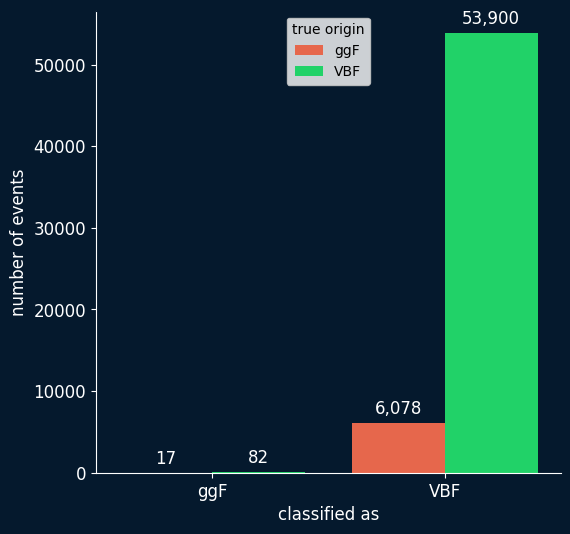

In [59]:
plot_confusion_barras(matriz, normalizado=False)